In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../ml/speech"))

# Any results you write to the current directory are saved as output.

['testing', 'writefile.wav', 'buffer2.wav', 'SavedPartition.pickle', 'SavedLabels.pickle', 'SavedTestLabels.pickle', 'buffer.wav', 'SavedTestDict.pickle']


In [2]:
# Imports
import pickle
import keras
import random
import scipy
import wave

from pathlib import Path
from subprocess import check_output

from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [3]:
train_audio_path = '../ml/datasets/speech/train/audio'

In [4]:
with open('../ml/speech/SavedPartition.pickle', 'rb') as handle:
    partition = pickle.load(handle)
with open('../ml/speech/SavedLabels.pickle', 'rb') as handle:
    labels = pickle.load(handle)
print("loaded data.")

loaded data.


In [5]:
def bandpass(sample_rate, samples):
    
    fs = sample_rate  # Sample frequency (Hz)
    fl = 180.0  # Human voices range from 85 Hz to 255 Hz
    fh = 240.0
    Q = 1.0  # Quality factor
    w0 = fl/(fs/2)  # Normalized Frequency
    w1 = fh/(fs/2)
    # Design notch filter
    b, a = scipy.signal.butter(3, [w0, w1], btype='bandpass', analog=True)
    samples = scipy.signal.lfilter(b,a,samples)*30

    return sample_rate, samples

def pitchshift(sample_rate, samples, shifthz):
    try:
        wavfile.write('../ml/speech/buffer.wav', sample_rate, samples)

        wr = wave.open('../ml/speech/buffer.wav', 'r')
        # Set the parameters for the output file.
        par = list(wr.getparams())
        par[3] = 0  # The number of samples will be set by writeframes.
        par = tuple(par)
        ww = wave.open('../ml/speech/writefile.wav', 'w')
        ww.setparams(par)

        fr = 20
        sz = wr.getframerate()//fr  # Read and process 1/fr second at a time.
        # A larger number for fr means less reverb.
        c = int(wr.getnframes()/sz)  # count of the whole file
        shift = shifthz//fr  # shifting 100 Hz

        for num in range(c):

            da = np.frombuffer(wr.readframes(sz), dtype=np.int16)
            left, right = da[0::2], da[1::2]
            lf, rf = np.fft.rfft(left), np.fft.rfft(right)
            lf, rf = np.roll(lf, shift), np.roll(rf, shift)
            lf[0:shift], rf[0:shift] = 0, 0
            nl, nr = np.fft.irfft(lf), np.fft.irfft(rf)
            ns = np.column_stack((nl, nr)).ravel().astype(np.int16)
            ww.writeframes(ns.tostring())

        sample_rate, samples = wavfile.read('../ml/speech/writefile.wav')
        wr.close()
        ww.close()
    except:
        return sample_rate, samples
    return sample_rate, samples

In [6]:
def spectrogram(sample_rate, samples):
    eps=1e-10
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
    
    # silence can end up being empty files, in this case we can just return one second of zeros
    if len(spectrogram.shape) < 2:
        return np.zeros((71,129))
    else:
        return np.log(np.abs(spectrogram).T+eps)

def stft(sample_rate, samples):

    eps=1e-10

    frequencies, times, Zxx = signal.stft(samples, sample_rate, nperseg = sample_rate/50, noverlap = sample_rate/75)
    
    # silence can end up being empty files, in this case we can just return one second of zeros
    if len(Zxx.shape) < 2:
        return np.zeros((151,161))
    else:
        return np.log(np.abs(Zxx).T+eps)

In [7]:
class DataGenerator(keras.utils.Sequence):
    # Generates data for Keras
    def __init__(self, list_IDs, labels, batch_size=32, dim=(151,161), x1dim=(71,129), x2dim=(151,161), n_channels=1,
                 n_classes=11, shuffle=True, input_type='wav', testing=False, augment=True):
        # Initialization
        self.dim = dim
        self.x1dim = x1dim
        self.x2dim = x2dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.input_type = input_type
        self.testing = testing
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # Generate one batch of data
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        if self.input_type == 'all':
            X1, X2, y = self.__data_generation(list_IDs_temp)
            if self.testing:
                return [X1,X2]
            else:
                return [X1,X2], [y]
        else:
            X, y = self.__data_generation(list_IDs_temp)
            
            return X, y

    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # Generates data containing batch_size samples # X : (n_samples, *dim, n_channels)
        # Initialization

        if self.input_type == 'all':
            X1 = np.empty((self.batch_size, *self.x1dim, self.n_channels))
            X2 = np.empty((self.batch_size, *self.x2dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data  
        if self.input_type == 'spectrogram':
            for i, ID in enumerate(list_IDs_temp):
                path = train_audio_path + '/'
                sample_rate, samples = wavfile.read(path + ID)

                if self.augment:
                    if random.randint(1,101) < 51 and len(samples)==16000:
                        sample_rate, samples = bandpass(sample_rate, samples)
                    if random.randint(1,101) < 51 and len(samples)==16000:
                        shifthz = random.randint(50,200)
                        sample_rate, samples = pitchshift(sample_rate, samples, shifthz)                        
                trans = spectrogram(sample_rate, samples)
                #last = ID, self.dim, spect.shape

                padded = np.zeros((self.x1dim))
                padded[:trans.shape[0], :trans.shape[1]] = trans
                X[i,] = padded[:, :, np.newaxis]
                y[i] = self.labels[ID]
                
            return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

        elif self.input_type == 'stft':
            for i, ID in enumerate(list_IDs_temp):
                path = train_audio_path + '/'
                sample_rate, samples = wavfile.read(path + ID)

                if self.augment:
                    if random.randint(1,101) < 51 and len(samples)==16000:
                        sample_rate, samples = bandpass(sample_rate, samples)
                    if random.randint(1,101) < 51 and len(samples)==16000:
                        shifthz = random.randint(50,200)
                        sample_rate, samples = pitchshift(sample_rate, samples, shifthz) 
                trans = stft(sample_rate, samples)
                #last = ID, self.dim, spect.shape

                padded = np.zeros((self.x2dim))
                padded[:trans.shape[0], :trans.shape[1]] = trans
                X[i,] = padded[:, :, np.newaxis]
                y[i] = self.labels[ID]
            
            return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
        
        elif self.input_type == 'all':
        
            for i, ID in enumerate(list_IDs_temp):
                path = train_audio_path + '/'
                sample_rate, samples = wavfile.read(path + ID)

                if self.augment:
                    if random.randint(1,101) < 51 and len(samples)==16000:
                        sample_rate, samples = bandpass(sample_rate, samples)
                    if random.randint(1,101) < 51 and len(samples)==16000:
                        shifthz = random.randint(50,200)
                        sample_rate, samples = pitchshift(sample_rate, samples, shifthz) 
                trans = spectrogram(sample_rate, samples)
                #last = ID, self.dim, spect.shape

                padded = np.zeros((self.x1dim))
                padded[:trans.shape[0], :trans.shape[1]] = trans
                X1[i,] = padded[:, :, np.newaxis]
                y[i] = self.labels[ID]
            for i, ID in enumerate(list_IDs_temp):
                path = train_audio_path + '/'
                sample_rate, samples = wavfile.read(path + ID)

                if self.augment:
                    if random.randint(1,101) < 51 and len(samples)==16000:
                        sample_rate, samples = bandpass(sample_rate, samples)
                    if random.randint(1,101) < 51 and len(samples)==16000:
                        shifthz = random.randint(50,200)
                        sample_rate, samples = pitchshift(sample_rate, samples, shifthz) 
                trans = stft(sample_rate, samples)
                #last = ID, self.dim, spect.shape

                padded = np.zeros((self.x2dim))
                padded[:trans.shape[0], :trans.shape[1]] = trans
                X2[i,] = padded[:, :, np.newaxis]
                
            return X1, X2, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [8]:
from keras.models import load_model

spect_model = load_model('../ml/models/spect_model.h5')
stft_model = load_model('../ml/models/stft_model.h5')

In [9]:
spect_model.layers.pop()
spect_model.compile

for layer in spect_model.layers:
    layer.name = "spect_" + layer.name
    
stft_model.layers.pop()
stft_model.compile

for layer in stft_model.layers:
    layer.name = "stft_" + layer.name

In [10]:
from keras.models import Sequential
from keras.callbacks import LearningRateScheduler
from keras.layers import concatenate, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

# Parameters
train_params = {
    'x1dim': (71,129),
    'x2dim': (151,161),
    'batch_size': 6,
    'n_classes':12,
    'n_channels': 1,
    'shuffle': True,
    'input_type': 'all',
    'augment':True
}

val_params = {
    'x1dim': (71,129),
    'x2dim': (151,161),
    'batch_size': 6,
    'n_classes':12,
    'n_channels': 1,
    'shuffle': False,
    'input_type': 'all',
    'augment':False
}

# Generators
training_generator = DataGenerator(partition['train'], labels, **train_params)
validation_generator = DataGenerator(partition['validation'], labels, **val_params)

spect_model_output = spect_model.get_layer('spect_dropout_3').output
stft_model_output = stft_model.get_layer('stft_dropout_3').output

concatenated = concatenate([spect_model_output, stft_model_output])
x = Dense(32, activation='relu')(concatenated)
prediction = Dense(12, activation='softmax', name='prediction')(x)
        
ensemble_model = Model([spect_model.input, stft_model.input], prediction)


ensemble_model.compile(optimizer = 'adam',
                       loss='categorical_crossentropy',
                       metrics=["accuracy"])

ensemble_model.summary()

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.98 ** x)

# Train model on dataset
history = ensemble_model.fit_generator(generator=training_generator,
                                       validation_data=validation_generator,
                                       steps_per_epoch=150,
                                       epochs=250,
                                       verbose=2,
                                       callbacks=[annealer]
                                      )

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spect_input_1 (InputLayer)      (None, 71, 129, 1)   0                                            
__________________________________________________________________________________________________
spect_conv2d_1 (Conv2D)         (None, 69, 127, 32)  320         spect_input_1[0][0]              
__________________________________________________________________________________________________
stft_input_1 (InputLayer)       (None, 151, 161, 1)  0                                            
__________________________________________________________________________________________________
spect_batch_normalization_1 (Ba (None, 69, 127, 32)  128         spect_conv2d_1[0][0]             
__________________________________________________________________________________________________
stft_conv2

Epoch 1/250
 - 50s - loss: 1.2559 - acc: 0.6711 - val_loss: 4.1286 - val_acc: 0.5234
Epoch 2/250
 - 41s - loss: 1.0125 - acc: 0.7000 - val_loss: 0.7221 - val_acc: 0.7818
Epoch 3/250
 - 41s - loss: 0.8198 - acc: 0.7489 - val_loss: 1.0622 - val_acc: 0.6970
Epoch 4/250
 - 41s - loss: 0.7870 - acc: 0.7689 - val_loss: 1.0083 - val_acc: 0.7240
Epoch 5/250
 - 41s - loss: 0.6144 - acc: 0.8044 - val_loss: 0.7629 - val_acc: 0.8174
Epoch 6/250
 - 41s - loss: 0.7151 - acc: 0.7800 - val_loss: 0.7143 - val_acc: 0.7689
Epoch 7/250
 - 41s - loss: 0.5866 - acc: 0.8156 - val_loss: 0.7339 - val_acc: 0.7671
Epoch 8/250
 - 41s - loss: 0.7208 - acc: 0.7878 - val_loss: 0.7084 - val_acc: 0.7960
Epoch 9/250
 - 41s - loss: 0.5975 - acc: 0.8211 - val_loss: 0.5823 - val_acc: 0.8113
Epoch 10/250
 - 41s - loss: 0.5778 - acc: 0.8189 - val_loss: 0.5018 - val_acc: 0.8423
Epoch 11/250
 - 42s - loss: 0.6075 - acc: 0.8144 - val_loss: 14.2826 - val_acc: 0.0987
Epoch 12/250
 - 41s - loss: 0.6823 - acc: 0.7967 - val_loss: 0

Epoch 97/250
 - 41s - loss: 0.2406 - acc: 0.9322 - val_loss: 0.2360 - val_acc: 0.9267
Epoch 98/250
 - 41s - loss: 0.2236 - acc: 0.9278 - val_loss: 0.2663 - val_acc: 0.9275
Epoch 99/250
 - 41s - loss: 0.2166 - acc: 0.9400 - val_loss: 0.2420 - val_acc: 0.9279
Epoch 100/250
 - 41s - loss: 0.2128 - acc: 0.9289 - val_loss: 0.2592 - val_acc: 0.9229
Epoch 101/250
 - 41s - loss: 0.1707 - acc: 0.9444 - val_loss: 0.2478 - val_acc: 0.9260
Epoch 102/250
 - 41s - loss: 0.1823 - acc: 0.9356 - val_loss: 0.2352 - val_acc: 0.9317
Epoch 103/250
 - 41s - loss: 0.1690 - acc: 0.9533 - val_loss: 0.2329 - val_acc: 0.9301
Epoch 104/250
 - 41s - loss: 0.2085 - acc: 0.9289 - val_loss: 0.2383 - val_acc: 0.9294
Epoch 105/250
 - 41s - loss: 0.1887 - acc: 0.9400 - val_loss: 0.2391 - val_acc: 0.9289
Epoch 106/250
 - 41s - loss: 0.2126 - acc: 0.9322 - val_loss: 0.2334 - val_acc: 0.9340
Epoch 107/250
 - 41s - loss: 0.1670 - acc: 0.9500 - val_loss: 0.2284 - val_acc: 0.9337
Epoch 108/250
 - 41s - loss: 0.1721 - acc: 0.9

Epoch 192/250
 - 41s - loss: 0.1315 - acc: 0.9522 - val_loss: 0.2193 - val_acc: 0.9353
Epoch 193/250
 - 41s - loss: 0.1527 - acc: 0.9556 - val_loss: 0.2174 - val_acc: 0.9363
Epoch 194/250
 - 41s - loss: 0.1826 - acc: 0.9522 - val_loss: 0.2163 - val_acc: 0.9365
Epoch 195/250
 - 41s - loss: 0.1465 - acc: 0.9544 - val_loss: 0.2211 - val_acc: 0.9362
Epoch 196/250
 - 41s - loss: 0.1232 - acc: 0.9589 - val_loss: 0.2188 - val_acc: 0.9348
Epoch 197/250
 - 41s - loss: 0.1501 - acc: 0.9578 - val_loss: 0.2163 - val_acc: 0.9365
Epoch 198/250
 - 41s - loss: 0.1420 - acc: 0.9633 - val_loss: 0.2152 - val_acc: 0.9373
Epoch 199/250
 - 41s - loss: 0.1671 - acc: 0.9489 - val_loss: 0.2144 - val_acc: 0.9372
Epoch 200/250
 - 41s - loss: 0.1375 - acc: 0.9611 - val_loss: 0.2140 - val_acc: 0.9373
Epoch 201/250
 - 41s - loss: 0.1445 - acc: 0.9611 - val_loss: 0.2152 - val_acc: 0.9370
Epoch 202/250
 - 41s - loss: 0.1332 - acc: 0.9589 - val_loss: 0.2130 - val_acc: 0.9381
Epoch 203/250
 - 41s - loss: 0.1450 - acc: 

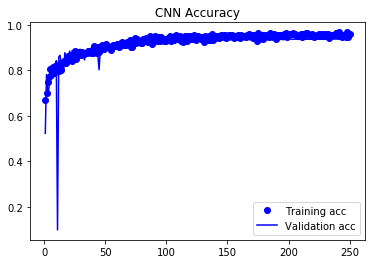

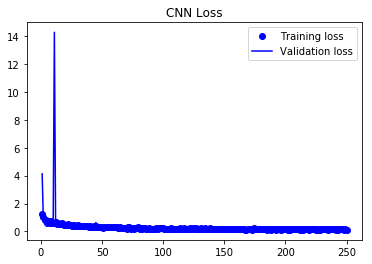

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('CNN Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('CNN Loss')
plt.legend()

plt.show()

In [12]:
ensemble_model.save('../ml/models/retrained_ensemble_model.h5')

In [13]:
import gc
gc.collect()

42844